## Data preparation

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

DATASET_DIR = (Path("..") / ".." / "datasets").resolve()
DATASETS = ["OFFICE-MANNERSDB", "MANNERSDBPlus"]
LABEL_COLS = [
    "Vaccum Cleaning", "Mopping the Floor", "Carry Warm Food",
    "Carry Cold Food", "Carry Drinks", "Carry Small Objects",
    "Carry Large Objects", "Cleaning", "Starting a conversation"
]

In [ ]:
def process_csv(csv_path, dataset):
    """Process individual CSV files"""
    df = pd.read_csv(csv_path)
    df = df.drop(columns=df.columns[-1])
    
    # Extract metadata from first column
    first_col = df.columns[0]
    split_data = df[first_col].str.split('_', n=2, expand=True)
    
    df["robot"] = split_data[0]
    df["domain"] = split_data[1]
    df["image_ref"] = split_data[2].astype(int)
    df["dataset"] = dataset

    df = df.drop(columns=[first_col])
    
    return df

def consolidate_data(datasets):
    """Aggregate all CSVs"""
    all_dfs = []
    for dataset in datasets:
        source_path = DATASET_DIR / dataset
        
        for robot in ["NAO", "Pepper", "PR2"]:
            ann_dir = source_path / robot / "Annotations"
            if not ann_dir.exists():
                raise ValueError(f"Labels csv file path ({ann_dir}) doesn't exist")
                
            
            for csv_file in ann_dir.glob("*.csv"):
                try:
                    df = process_csv(csv_file, dataset)
                    all_dfs.append(df)
                except Exception as e:
                    print(f"Error processing {csv_file}: {str(e)}")
    
    df = pd.concat(all_dfs, ignore_index=True)

    return df

In [ ]:
def validate_raw_data(df):
    """Comprehensive data quality checks for raw annotation data"""
    required_columns = {'robot', 'domain', 'image_ref', 'dataset'}

    # Check for any missing columns
    missing_cols = required_columns - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Label value validation (should be between 1 and 5)
    for col in LABEL_COLS:
        if df[col].min() < 1 or df[col].max() > 5:
            raise ValueError(f"Label {col} has invalid range [{df[col].min()}, {df[col].max()}]")

    # Null values check
    null_cols = df.columns[df.isnull().any()].tolist()
    if null_cols:
        raise ValueError(f"Null values found in columns: {null_cols}")

    # Data type and value validation for image_ref
    if not pd.api.types.is_integer_dtype(df['image_ref']):
        raise TypeError("image_ref must be integer type")
    if (df['image_ref'] < 0).any():
        raise ValueError("image_ref contains negative values, which is invalid")

    # Categorical value validation
    valid_robots = {'NAO', 'Pepper', 'PR2'}
    invalid_robots = set(df['robot']) - valid_robots
    if invalid_robots:
        raise ValueError(f"Invalid robot values: {invalid_robots}")

    valid_sources = {'OFFICE-MANNERSDB', 'MANNERSDBPlus'}
    invalid_sources = set(df['dataset']) - valid_sources
    if invalid_sources:
        raise ValueError(f"Invalid source directories: {invalid_sources}")

    return True


In [ ]:
def aggregate_labels(df):
    """Aggregate multiple annotations per image by image path"""    
    agg_dict = {
        **{col: 'mean' for col in LABEL_COLS},
        **{col: 'first' for col in df.columns.difference(LABEL_COLS).tolist()},
    }
    
    return df.groupby('image_path', as_index=False).agg(agg_dict)


In [ ]:
def resolve_image_path(row):
    """Robust path resolution with validation"""
    base_dir = DATASET_DIR / row['dataset'] / row['robot'] / "Images"
    
    if row['dataset'] == "OFFICE-MANNERSDB":
        target = base_dir / f"{row['domain']}_{row['image_ref']}.png"
    else:
        target = next(base_dir.glob(f"{row['image_ref']}_*.png"), None)
    
    if target and target.exists():
        return str(target.resolve())
    return None

In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
            
        img_path = str(self.df.at[idx, "image_path"])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Error loading {img_path}: {str(e)}")
        
        raw_labels = self.df.iloc[idx][LABEL_COLS].values.astype(np.float32)
        scaled_labels = (raw_labels - 1) / 4  # Convert 1-5 → 0-1
        domain_labels = self.df.at[idx, 'domain']

        if self.transform:
            image = self.transform(image)
            
        return image, torch.from_numpy(scaled_labels), domain_labels

In [ ]:
def create_dataloaders(df, batch_sizes=(32, 64, 64), resize_img_to=(128, 128)):
    """Create train/val/test dataloaders using image_path as unique key"""
    
    # Get image paths as indexing for split
    unique_images = df[['image_path']].reset_index(drop=True)
    
    # Split using image_path as key #TODO is is spliting based on index or path strings? index faster
    train_paths, temp_paths = train_test_split(
        unique_images['image_path'], 
        test_size=0.3, 
        random_state=42
    )
    val_paths, test_paths = train_test_split(
        temp_paths,
        test_size=0.5, 
        random_state=42
    )
   
    # Create subsets
    train_df = df[df['image_path'].isin(train_paths)].reset_index(drop=True)
    val_df = df[df['image_path'].isin(val_paths)].reset_index(drop=True)
    test_df = df[df['image_path'].isin(test_paths)].reset_index(drop=True)
    
    #TODO add coordinate values for spacialy aware CNN Uber's CoordNav
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize(resize_img_to),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = ImageLabelDataset(train_df, transform)
    val_dataset = ImageLabelDataset(val_df, transform)
    test_dataset = ImageLabelDataset(test_df, transform)
    
    # Create loaders
    num_workers = 0
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_sizes[0], shuffle=True, num_workers=num_workers, pin_memory=torch.cuda.is_available()),
        'val': DataLoader(val_dataset, batch_size=batch_sizes[1], shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available()),
        'test': DataLoader(test_dataset, batch_size=batch_sizes[2], shuffle=False, num_workers=num_workers, pin_memory=torch.cuda.is_available())
    }
    
    return loaders


In [ ]:
def validate_final_data(df):
    """Final validation after aggregation"""
    # Missing image paths
    missing = df[df['image_path'].isnull()]
    if not missing.empty:
        raise FileNotFoundError(
            f"{len(missing)} images missing after aggregation. Examples:\n"
            f"{missing[['robot', 'domain', 'image_ref']].head()}"
        )
    
    # Null values check
    null_cols = df.columns[df.isnull().any()].tolist()
    if null_cols:
        raise ValueError(f"Null values found in columns: {null_cols}")

    # Duplicate image paths
    duplicates = df[df.duplicated('image_path', keep=False)]
    if not duplicates.empty:
        raise RuntimeError(
            f"Duplicate image paths after aggregation:\n"
            f"{duplicates['image_path'].unique()}"
        )

    # Label validity (1-5)
    for col in LABEL_COLS:
        if df[col].min() < 1 or df[col].max() > 5:
            raise ValueError(
                f"Aggregated label {col} out of range: "
                f"[{df[col].min()}, {df[col].max()}]"
            )

    return True


## --

In [ ]:
try:
    raw_df = consolidate_data(DATASETS)
    validate_raw_data(raw_df)
    raw_df['image_path'] = raw_df.apply(resolve_image_path, axis=1)   
    aggregated_df = aggregate_labels(raw_df)
    validate_final_data(aggregated_df) 
except Exception as e:
    print(f"Pipeline failed: {str(e)}")
    raise

aggregated_df.to_pickle("../data/processed_all_data.pkl")


## CL Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from collections import deque
import random
import time
import torch.nn.functional as F
from torch.utils.data import Subset, ConcatDataset, DataLoader

In [ ]:
class SocialContinualModel(nn.Module):
    def __init__(self, num_tasks=9):
        super().__init__()
        # Initialize the ResNet50 architecture with Places365 configuration
        self.backbone = models.resnet50(num_classes=365)
        
        # get Places365 weights and fix their naming leftover from troch saving convention
        places365_weights = torch.load('resnet50_places365.pth.tar', weights_only=True)
        state_dict = places365_weights['state_dict']
        state_dict = {k.replace('module.', ''): v 
                     for k, v in state_dict.items()}
        
        # Load weights
        self.backbone.load_state_dict(state_dict)
        
        # Remove classification head
        self.backbone.fc = nn.Identity()

        #Freeze all params except last layer
        for name, param in self.backbone.named_parameters():
            if 'layer4' not in name:
                param.requires_grad_(False)
        
        #TODO human mask average, std, quadrants, human in realtion to robot std
        


        # Shared layers #TODO deeper shared space?
        self.shared_fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Task-specific heads with more expensive but finegrained GELU
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1024, 512),
                nn.GELU(),
                nn.Linear(512, 1),
                nn.Sigmoid()
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        features = self.backbone(x)
        shared = self.shared_fc(features)
        outputs = [head(shared) for head in self.heads]
        return torch.cat(outputs, dim=1)


In [ ]:
import torch.nn as nn
from torchvision import models

class LGRBaseline(nn.Module):
    """
    @misc{churamani_feature_2024,
		title = {Feature Aggregation with Latent Generative Replay for Federated Continual Learning of Socially Appropriate Robot Behaviours},
		url = {http://arxiv.org/abs/2405.15773},
		doi = {10.48550/arXiv.2405.15773},
		number = {{arXiv}:2405.15773},
		publisher = {{arXiv}},
		author = {Churamani, Nikhil and Checker, Saksham and Chiang, Hao-Tien Lewis and Gunes, Hatice},
		urldate = {2025-01-30},
		date = {2024-03-16},
	}
    """
    def __init__(self, num_classes=9):
        super(LGRBaseline, self).__init__()
        
        # MobileNetV2 backbone
        self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features
        
        # Backbone feature processing
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # Regression head
        self.fc1_bn = nn.BatchNorm1d(1280)
        self.fc2 = nn.Linear(1280, 32)
        # self.fc2_bn = nn.BatchNorm1d(128)
		# self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        # Feature extraction
        x = self.backbone(x)
        
        # Spatial reduction
        x = self.pool(x)
        x = self.flatten(x)
        
        # Regression
        x = self.fc1_bn(x)
        x = self.fc2(x)
        # x = self.fc2_bn(x)
		# x = self.fc3(x)
        x = self.fc4(x)
        
        return {'output': x}


In [ ]:
import torch
import random
import pandas as pd

class ReservoirBuffer:
    def __init__(self, capacity=1000, replay_ratio=0.2, input_shape=(3, 384, 216), label_shape=(9,), device=torch.device('cpu')):
        self.capacity = capacity
        self.inputs = torch.empty((capacity, *input_shape), dtype=torch.float32, device=device)
        self.labels = torch.empty((capacity, *label_shape), dtype=torch.float32, device=device)
        self.domains = [None] * capacity
        self.size = 0          # Number of samples currently in buffer
        self.num_seen = 0      # Total samples seen
        self.replay_ratio = replay_ratio

    def add(self, new_samples):
        for sample in new_samples:
            self.num_seen += 1
            if self.size < self.capacity:
                idx = self.size
                self.size += 1
            else:
                idx = random.randint(0, self.num_seen - 1)
                if idx >= self.capacity:
                    continue
            self.inputs[idx].copy_(sample[0])
            self.labels[idx].copy_(sample[1])
            self.domains[idx] = sample[2]

    def sample(self, batch_size):
        if self.size == 0:
            return []
        indices = torch.randint(0, self.size, (batch_size,))
        return [(self.inputs[i], self.labels[i], self.domains[i]) for i in indices]

    def __len__(self):
        return self.size

    def get_domain_distribution(self):
        return pd.Series(self.domains[:self.size]).value_counts()


In [ ]:
class NaiveRehearsalBuffer:
    """
    @inproceedings{Hsu18_EvalCL,
        title={Re-evaluating Continual Learning Scenarios: A Categorization and Case for Strong Baselines},
        author={Yen-Chang Hsu and Yen-Cheng Liu and Anita Ramasamy and Zsolt Kira},
        booktitle={NeurIPS Continual learning Workshop },
        year={2018},
        url={https://arxiv.org/abs/1810.12488}
    }
    """
    def __init__(self, buffer_size=1000):
        self.buffer_size = buffer_size
        self.domain_buffer = {}

    def update_buffer(self, domain, dataset):
        # Add/overwrite current domain
        self.domain_buffer[domain] = Subset(dataset, torch.arange(len(dataset)))
        
        # Recalculate quota
        num_domains = len(self.domain_buffer)
        buffer_quota_per_domain = self.buffer_size // num_domains
        
        # Reduce all domains (including current)
        for domain in self.domain_buffer:
            subset = self.domain_buffer[domain]
            max_safe_samples_to_overwrite = min(buffer_quota_per_domain, len(subset.dataset))
            rand_indices = torch.randperm(len(dataset))[:max_safe_samples_to_overwrite].numpy()
            self.domain_buffer[domain] = Subset(dataset, rand_indices)

    def get_loader_with_replay(self, current_domain, current_loader):
        current_dataset = current_loader.dataset
        replay_datasets = [dataset for domain, dataset in self.domain_buffer.items() if domain != current_domain]

        #Enforces 1:1 ratio when current ≥ buffer
        total_replay = sum(len(dataset) for dataset in replay_datasets)
        if total_replay > 0:
            K = max(len(current_dataset) // total_replay, 1)
            replay_datasets = replay_datasets * K

        combined_dataset =  ConcatDataset(replay_datasets + [current_dataset])
        combined_dataset = DataLoader(
            combined_dataset,
            batch_size=current_loader.batch_size,
            shuffle=True,
            num_workers=current_loader.num_workers,
            pin_memory=current_loader.pin_memory,
            drop_last=current_loader.drop_last
        )
        return combined_dataset
    
    def get_domain_distribution(self):
        """Returns {domain: num_samples} without needing Storage"""
        return {domain: len(subset) for domain, subset in self.domain_buffer.items()}



In [ ]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x
    @staticmethod
    def backward(ctx, grad_output):
        return -grad_output

class GradientReversal(nn.Module):
    def forward(self, x):
        return GradientReversalFunction.apply(x)


class DualBranchNet(nn.Module):
    def __init__(self, num_outputs=9, num_domains=6, weights_init=False, weights_norm=False):
        super().__init__()

        def linear(in_f, out_f):
            layer = nn.Linear(in_f, out_f)
            return torch.nn.utils.parametrizations.weight_norm(layer, dim=0) if weights_norm else layer 
        
        def layer_norm(dim):
            return nn.Identity() if weights_norm else nn.LayerNorm(dim)

        self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_dim = 1280

        self.invariant = nn.Sequential(
            linear(self.feature_dim, 256),
            GradientReversal(),
            layer_norm(256),
            nn.ReLU(),
            linear(256, 256)
        )

        self.invariant_domain_classifier = nn.Sequential(
            layer_norm(256),
            nn.Linear(256, num_domains)
        )
        
        self.specific = nn.Sequential(
            linear(self.feature_dim, 256),
            layer_norm(256), 
            nn.ReLU(),
            linear(256, 256)
        )
        
        self.specific_domain_classifier = nn.Sequential(
            layer_norm(256),
            nn.Linear(256, num_domains)
        )
        
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )

        if weights_init:
            self._init_weights()

    def _init_weights(self):
        custom_modules = [
            'invariant',
            'invariant_domain_classifier',
            'specific',
            'specific_domain_classifier',
            'head'
        ]
        for name in custom_modules:
            module = getattr(self, name, None)
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.orthogonal_(m.weight)
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        base = self.backbone(x)
        base = self.pool(base).view(x.size(0), -1)
        
        invariant_feats = self.invariant(base)
        invariant_domain_pred = self.invariant_domain_classifier(invariant_feats)

        specific_feats = self.specific(base)
        specific_domain_pred = self.specific_domain_classifier(specific_feats)

        combined = torch.cat([invariant_feats, specific_feats], dim=1)
        
        scores = self.head(combined)      
        
        return {
            'output': scores,
            'invariant_domain': invariant_domain_pred,
            'specific_domain': specific_domain_pred,
            'invariant_feats': invariant_feats,
            'specific_feats': specific_feats
        }


In [ ]:
class DualBranchNet_deep(DualBranchNet):
    """thicker invariant network to learn features instead of realying on the backbone"""
    def __init__(self, num_outputs=9, num_domains=6, weights_init=True, weights_norm=False):
        super().__init__(num_outputs, num_domains, weights_init, weights_norm)

        def linear(in_f, out_f):
            layer = nn.Linear(in_f, out_f)
            return torch.nn.utils.parametrizations.weight_norm(layer, dim=0) if weights_norm else layer 

        self.invariant = nn.Sequential(
            linear(self.feature_dim, 512),
            nn.ReLU(),
            linear(512, 256),
            nn.ReLU(),
            linear(256, 256)
        )

        self.invariant_domain_classifier = nn.Sequential(
            GradientReversal(),
            nn.Linear(256, num_domains)
        )

## ---

In [ ]:
import shutil

def extract_data_subset(df, robot_name='Pepper'):
    # Modify the saving section at the end
    # Create the required directory structure
    project_root = Path.cwd().parent  # Goes up from experiments/ to project/
    data_dir = project_root / "data"
    images_dir = data_dir / "images"

    images_dir.mkdir(parents=True, exist_ok=True)

    # Filter for Pepper first
    pepper_df = df[df['robot'] == robot_name].copy()
    pepper_df = pepper_df.reset_index(drop=True)

    # Copy images and update paths
    def copy_and_update_path(row):
        src_path = Path(row['image_path'])
        dst_path = images_dir / src_path.name
        
        if not dst_path.exists():
            shutil.copy2(src_path, dst_path)
        
        return str(dst_path.relative_to(project_root))

    pepper_df['image_path'] = pepper_df.apply(copy_and_update_path, axis=1)

    # Save the filtered dataframe
    pepper_df.to_pickle(data_dir / "pepper_data.pkl")
    return pepper_df


In [ ]:
df = pd.read_pickle("../data/pepper_data.pkl")
df['image_path'] = '../' + df['image_path']

# Create domain-specific dataloaders
domains = df['domain'].unique()
domain_dataloaders = {}
for domain in domains:
    domain_df = df[df['domain'] == domain]
    #domain_df = domain_df.sample(frac=0.5, random_state=42)
    loaders = create_dataloaders(domain_df, batch_sizes=(32, 64, 64), resize_img_to=(128, 128))  #TODO should be (384, 216) to retain scale or (224, 224) for best performance on MobileNet
    domain_dataloaders[domain] = loaders

## Training

In [ ]:
# For LGRBaseline
def baseline_batch(model, batch, device, **kwargs):
    inputs, labels, _ = batch
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)['output']
    loss = kwargs['mse_criterion'](outputs, labels)
    metrics = {}
    return loss, metrics

# For DualBranchNet
def dualbranch_batch(model, batch, device, **kwargs):
    inputs, labels, domain_labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    domain_to_idx = kwargs['domain_to_idx']
    domain_labels = torch.tensor([domain_to_idx[d] for d in domain_labels], device=device)
    mse_criterion = kwargs['mse_criterion']
    ce_criterion = kwargs['ce_criterion']
    cos_criterion = kwargs['cos_criterion']

    # Split batch
    current_domain = kwargs['current_domain']
    current_mask = (domain_labels == domain_to_idx[current_domain])
    replay_mask = ~current_mask

    # 1. Current samples: update all parameters
    if current_mask.any():
        inputs_current = inputs[current_mask]
        labels_current = labels[current_mask]
        domain_labels_current = domain_labels[current_mask]

        outputs_current = model(inputs_current)
        inv_feats = outputs_current['invariant_feats']
        spec_feats = outputs_current['specific_feats']

        task_loss = mse_criterion(outputs_current['output'], labels_current)
        inv_domain_loss = ce_criterion(outputs_current['invariant_domain'], domain_labels_current)
        spec_domain_loss = ce_criterion(outputs_current['specific_domain'], domain_labels_current)
        similarity_loss = cos_criterion(inv_feats, spec_feats)
        
        total_loss = (task_loss +
                      0.5 * inv_domain_loss +
                      0.2 * spec_domain_loss +
                      0.1 * similarity_loss)
        
        total_loss.backward(retain_graph=True)
        
        inv_acc = (outputs_current['invariant_domain'].argmax(1) == domain_labels_current).float().mean().item()
        spec_acc = (outputs_current['specific_domain'].argmax(1) == domain_labels_current).float().mean().item()
    else:
        total_loss = torch.tensor(0.0, device=device)
        inv_acc = 0.0
        spec_acc = 0.0
        task_loss = torch.tensor(0.0, device=device)
        inv_domain_loss = torch.tensor(0.0, device=device)
        spec_domain_loss = torch.tensor(0.0, device=device)
        similarity_loss = torch.tensor(0.0, device=device)

    # 2. Replay samples: update only specific branch + head
    if replay_mask.any():
        inputs_replay = inputs[replay_mask]
        labels_replay = labels[replay_mask]
        domain_labels_replay = domain_labels[replay_mask]

        #no_grad, unlike requires_grad=False, detaches all elements from the gradient computation graph
        with torch.no_grad():
            base_replay = model.backbone(inputs_replay)
            base_replay = model.pool(base_replay).flatten(1)
            inv_feats_replay = model.invariant(base_replay)

        specific_feats = model.specific(base_replay)
        spec_domain_pred = model.specific_domain_classifier(specific_feats)

        combined = torch.cat([inv_feats_replay, specific_feats], dim=1)  
        scores = model.head(combined)
        
        task_loss_replay = mse_criterion(scores, labels_replay)
        spec_domain_loss_replay = ce_criterion(spec_domain_pred, domain_labels_replay)
        total_loss_replay = task_loss_replay + 0.2 * spec_domain_loss_replay
        
        total_loss_replay.backward()
    
    metrics = {
        'task_loss': task_loss.item(),
        'inv_domain': inv_domain_loss.item(),
        'spec_domain': spec_domain_loss.item(),
        'similarity': similarity_loss.item(),
        'inv_acc': inv_acc,
        'spec_acc': spec_acc,
        'replay_count': replay_mask.sum().item(),
        'current_count': current_mask.sum().item()
    }
    return total_loss, metrics


In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:

            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            outputs = model(inputs)['output']
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    return total_loss / total_samples

def cross_domain_validation(model, domain_dataloaders, criterion, device):
    results = {}
    for domain, loaders in domain_dataloaders.items():
        val_loader = loaders['val']
        val_loss = evaluate_model(model, val_loader, criterion, device)
        results[domain] = val_loss
    return results

def average_metrics(metrics_list):
    # metrics_list: list of dicts, each dict contains metrics for a batch
    if not metrics_list:
        return {}
    keys = metrics_list[0].keys()
    avg_metrics = {}
    for k in keys:
        avg_metrics[k] = float(np.mean([m[k] for m in metrics_list if k in m]))
    return avg_metrics

def collect_tsne_features(model, loader, device):
    model.eval()
    all_inv, all_spec, all_domains = [], [], []
    with torch.no_grad():
        for domain, loaders in domain_dataloaders.items():
            loader = loaders['val']
            for x, _, d in loader:
                x = x.to(device)
                out = model(x)
                all_inv.append(out['invariant_feats'].cpu())
                all_spec.append(out['specific_feats'].cpu())
                all_domains += list(d)
    inv_feats = torch.cat(all_inv, dim=0).numpy()
    spec_feats = torch.cat(all_spec, dim=0).numpy()
    return inv_feats, spec_feats, all_domains

def collect_gradients(model):
    grad_norms = {}
    for name, param in model.named_parameters():
        if param.grad is not None and not name.startswith("backbone"):
            module = name.split('.')[0]
            norm = param.grad.norm(2).item()
            if module not in grad_norms:
                grad_norms[module] = []
            grad_norms[module].append(norm)
    # Take mean per module
    grad_norms = {k: float(np.mean(v)) for k, v in grad_norms.items()}
    return grad_norms


In [ ]:
import pickle
import torch
from tqdm import tqdm

def unified_train_loop(
    model, domains, domain_dataloaders, buffer, optimizer, writer, device,
    batch_fn, batch_kwargs, num_epochs=5, exp_name="exp", gradient_clipping=False
):
    global_step = 0
    history = {
        'train_epoch_loss': [],
        'val_epoch_loss': [],
        'train_epoch_metrics': [],
        'cross_domain_val': [],
        'grad_norms': [],
    }
    for domain_idx, current_domain in enumerate(domains):
        print(buffer.get_domain_distribution())
        train_loader = buffer.get_loader_with_replay(current_domain, domain_dataloaders[current_domain]['train'])
        
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            samples = 0
            batch_metrics_list = []
            
            # for batch_idx, batch in enumerate(train_loader):
            for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Domain {current_domain} Epoch {epoch+1}/{num_epochs}")):
                optimizer.zero_grad()
                loss, metrics = batch_fn(model, batch, device, **{**batch_kwargs, 'current_domain': current_domain})
                if gradient_clipping:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                batch_size = batch[0].size(0)
                epoch_loss += loss.item() * batch_size
                samples += batch_size
                global_step += 1
                batch_metrics_list.append(metrics)
                # TensorBoard logging (every 10 batches)
                if writer and batch_idx % 10 == 0:
                    writer.add_scalar(f'{exp_name}/train_loss', loss.item(), global_step)
                    for k, v in metrics.items():
                        writer.add_scalar(f'{exp_name}/train_{k}', v, global_step)
            avg_epoch_loss = epoch_loss / samples
            writer.add_scalar(f'{exp_name}/train_epoch_loss', avg_epoch_loss, global_step)
            history['train_epoch_loss'].append(avg_epoch_loss)
            # Average batch metrics for this epoch
            avg_metrics = average_metrics(batch_metrics_list)
            history['train_epoch_metrics'].append(avg_metrics)

            # Collect gradients
            grad_norms = collect_gradients(model)
            history['grad_norms'].append(grad_norms)

            # Validation on current domain
            val_loss = evaluate_model(model, domain_dataloaders[current_domain]['val'], batch_kwargs['mse_criterion'], device)
            writer.add_scalar(f'{exp_name}/val_epoch_loss', val_loss, global_step)
            history['val_epoch_loss'].append(val_loss)

            # Collect data for t-SNE domain separation graphs
            inv_feats, spec_feats, domain_labels = collect_tsne_features(model, domain_dataloaders, device)
            tsne_data = {
                'inv_feats': inv_feats,
                'spec_feats': spec_feats,
                'domain_labels': domain_labels
            }

            # Cross-domain validation (after each domain)
            if epoch == num_epochs-1:
                cross_val = cross_domain_validation(model, domain_dataloaders, batch_kwargs['mse_criterion'], device)
                history['cross_domain_val'].append(cross_val)

            # Save model and metrics
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'tsne' : tsne_data,
            }, f"../checkpoints/{exp_name}_domain{current_domain}_epoch{epoch}_step{global_step}.pt")
            with open(f"../checkpoints/{exp_name}_history.pkl", "wb") as f:
                pickle.dump(history, f)
            
        buffer.update_buffer(current_domain, domain_dataloaders[current_domain]['train'].dataset)
    return history


In [ ]:
import datetime
from torch.utils.tensorboard import SummaryWriter

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
domains = df['domain'].unique()
domain_to_idx = {d: i for i, d in enumerate(domains)}

# # For baseline model
# baseline_model = LGRBaseline().to(device)
# optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
# buffer = NaiveRehearsalBuffer(buffer_size=1000)
# exp_name = f"baselinemodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
# writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

# baseline_kwargs = {'mse_criterion': nn.MSELoss()}
# unified_train_loop(
#     model=baseline_model,
#     domains=domains,
#     domain_dataloaders=domain_dataloaders,
#     buffer=buffer,
#     optimizer=optimizer,
#     writer=writer,
#     device=device,
#     batch_fn=baseline_batch,
#     batch_kwargs=baseline_kwargs,
#     num_epochs=10,
#     exp_name=exp_name
# )

# For DualBranchNet
dual_model = DualBranchNet(num_domains=len(domains)).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(buffer_size=1000)

def cos_criterion(a, b):
    return (1 - torch.abs(nn.CosineSimilarity()(a, b))).mean()
    # return (nn.CosineSimilarity()(a, b) ** 2).mean()

exp_name = f"nores_dualbranchmodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

dualbranch_kwargs = {
    'mse_criterion': nn.MSELoss(),
    'ce_criterion': nn.CrossEntropyLoss(),
    'cos_criterion': cos_criterion,
    'domain_to_idx': domain_to_idx
}
unified_train_loop(
    model=dual_model,
    domains=domains,
    domain_dataloaders=domain_dataloaders,
    buffer=buffer,
    optimizer=optimizer,
    writer=writer,
    device=device,
    batch_fn=dualbranch_batch,
    batch_kwargs=dualbranch_kwargs,
    num_epochs=10,
    exp_name=exp_name,
    gradient_clipping=False
)


# For DualBranchNet
dual_model = DualBranchNet(num_domains=len(domains)).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(buffer_size=1000)

def cos_criterion(a, b):
    return (1 - torch.abs(nn.CosineSimilarity()(a, b))).mean()
    # return (nn.CosineSimilarity()(a, b) ** 2).mean()

exp_name = f"nores_gradclip_dualbranchmodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

dualbranch_kwargs = {
    'mse_criterion': nn.MSELoss(),
    'ce_criterion': nn.CrossEntropyLoss(),
    'cos_criterion': cos_criterion,
    'domain_to_idx': domain_to_idx
}
unified_train_loop(
    model=dual_model,
    domains=domains,
    domain_dataloaders=domain_dataloaders,
    buffer=buffer,
    optimizer=optimizer,
    writer=writer,
    device=device,
    batch_fn=dualbranch_batch,
    batch_kwargs=dualbranch_kwargs,
    num_epochs=10,
    exp_name=exp_name,
    gradient_clipping=True
)

# For DualBranchNet
dual_model = DualBranchNet(weights_init=True, weights_norm=True).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(buffer_size=1000)

def cos_criterion(a, b):
    return (1 - torch.abs(nn.CosineSimilarity()(a, b))).mean()
    # return (nn.CosineSimilarity()(a, b) ** 2).mean()

exp_name = f"nores_winit_wnorm_dualbranchmodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

dualbranch_kwargs = {
    'mse_criterion': nn.MSELoss(),
    'ce_criterion': nn.CrossEntropyLoss(),
    'cos_criterion': cos_criterion,
    'domain_to_idx': domain_to_idx
}
unified_train_loop(
    model=dual_model,
    domains=domains,
    domain_dataloaders=domain_dataloaders,
    buffer=buffer,
    optimizer=optimizer,
    writer=writer,
    device=device,
    batch_fn=dualbranch_batch,
    batch_kwargs=dualbranch_kwargs,
    num_epochs=10,
    exp_name=exp_name,
    gradient_clipping=False
)

# For DualBranchNet
dual_model = DualBranchNet(weights_init=True, weights_norm=True).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(buffer_size=1000)

def cos_criterion(a, b):
    return (1 - torch.abs(nn.CosineSimilarity()(a, b))).mean()
    # return (nn.CosineSimilarity()(a, b) ** 2).mean()

exp_name = f"nores_gradclip_winit_wnorm_dualbranchmodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

dualbranch_kwargs = {
    'mse_criterion': nn.MSELoss(),
    'ce_criterion': nn.CrossEntropyLoss(),
    'cos_criterion': cos_criterion,
    'domain_to_idx': domain_to_idx
}
unified_train_loop(
    model=dual_model,
    domains=domains,
    domain_dataloaders=domain_dataloaders,
    buffer=buffer,
    optimizer=optimizer,
    writer=writer,
    device=device,
    batch_fn=dualbranch_batch,
    batch_kwargs=dualbranch_kwargs,
    num_epochs=10,
    exp_name=exp_name,
    gradient_clipping = True
)


In [ ]:
import datetime
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
domains = df['domain'].unique()
domain_to_idx = {d: i for i, d in enumerate(domains)}

dual_model = DualBranchNet_deep(weights_init=True, weights_norm=False).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(buffer_size=1000)

def cos_criterion(a, b):
    return (1 - torch.abs(nn.CosineSimilarity()(a, b))).mean()
    # return (nn.CosineSimilarity()(a, b) ** 2).mean()

exp_name = f"deep_dualbranchmodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

dualbranch_kwargs = {
    'mse_criterion': nn.MSELoss(),
    'ce_criterion': nn.CrossEntropyLoss(),
    'cos_criterion': cos_criterion,
    'domain_to_idx': domain_to_idx
}
unified_train_loop(
    model=dual_model,
    domains=domains,
    domain_dataloaders=domain_dataloaders,
    buffer=buffer,
    optimizer=optimizer,
    writer=writer,
    device=device,
    batch_fn=dualbranch_batch,
    batch_kwargs=dualbranch_kwargs,
    num_epochs=10,
    exp_name=exp_name,
    gradient_clipping=True
)


dual_model = DualBranchNet_deep(weights_init=True, weights_norm=True).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(buffer_size=1000)

def cos_criterion(a, b):
    return (1 - torch.abs(nn.CosineSimilarity()(a, b))).mean()
    # return (nn.CosineSimilarity()(a, b) ** 2).mean()

exp_name = f"deep_norm_dualbranchmodel_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
writer = SummaryWriter(log_dir=f"../tensorboard/{exp_name}")

dualbranch_kwargs = {
    'mse_criterion': nn.MSELoss(),
    'ce_criterion': nn.CrossEntropyLoss(),
    'cos_criterion': cos_criterion,
    'domain_to_idx': domain_to_idx
}
unified_train_loop(
    model=dual_model,
    domains=domains,
    domain_dataloaders=domain_dataloaders,
    buffer=buffer,
    optimizer=optimizer,
    writer=writer,
    device=device,
    batch_fn=dualbranch_batch,
    batch_kwargs=dualbranch_kwargs,
    num_epochs=10,
    exp_name=exp_name,
    gradient_clipping=True
)

In [ ]:
# Ideas for potential ways to combine networks
residual = SpecificHead(base + invariant_feats)
specific_feats = invariant_feats + residual

gate = GateNet(base + invariant_feats)
residual = SpecificHead(base)
specific_feats = invariant_feats + gate * residual

residual = Attention(invariant_feats, base)
specific_feats = invariant_feats + residual

gamma, beta = SpecificHead(base)
specific_feats = gamma * invariant_feats + beta

invariant_feats = InvariantHead(base)
specific_feats = SpecificHead(base)
cos_sim(invariant_feats, specific_feats) ~ 0


In [ ]:
# different cos 1-abs fixed residual - fixedred_fixedcos_dualbranchmodel_20250604_014811_history
#fixed res but old cosine ^2 - fixedred_dualbranchmodel_20250604_002951_history
#broken baseline - baselinemodel_20250603_200948_history
# recent dualbranch - dualbranchmodel_20250603_135728_history
#normalised and standarised residual - dualbranchmodel_20250609_013632_history
#standarised residual - nonorm_dualbranchmodel_20250609_131820_history
#no residual connection - nores_dualbranchmodel_20250609_232842_history
#same plus gradient clipping - nores_gradclip_dualbranchmodel_20250610_010647_history
#same, no graidient clipping, weights initialisation and normalisation - nores_winit_wnorm_dualbranchmodel_20250610_024401_history
#same, gradient clipping and weights optimisation - nores_gradclip_winit_wnorm_dualbranchmodel_20250610_042118_history

with open('../checkpoints/nonorm_dualbranchmodel_20250609_131820_history.pkl', 'rb') as f:
    history = pickle.load(f)

with open('../checkpoints/nores_dualbranchmodel_20250609_232842_history.pkl', 'rb') as f:
    history_nores = pickle.load(f)

with open('../checkpoints/nores_gradclip_dualbranchmodel_20250610_010647_history.pkl', 'rb') as f:
    history_nores_gradclip = pickle.load(f)

with open('../checkpoints/dualbranchmodel_20250609_013632_history.pkl', 'rb') as f:
    history_lnorm = pickle.load(f)

with open('../checkpoints/nores_winit_wnorm_dualbranchmodel_20250610_024401_history.pkl', 'rb') as f:
    history_nores_wnorm = pickle.load(f)

with open('../checkpoints/nores_gradclip_winit_wnorm_dualbranchmodel_20250610_042118_history.pkl', 'rb') as f:
    history_nores_gradclip_wnorm = pickle.load(f)

In [99]:
#deeper invariant network - deep_norm_dualbranchmodel_20250610_223350_history
#same but with weiths normalisation - deep_dualbranchmodel_20250610_205411_history

with open('../checkpoints/deep_norm_dualbranchmodel_20250610_223350_history.pkl', 'rb') as f:
    deep_norm = pickle.load(f)

with open('../checkpoints/deep_dualbranchmodel_20250610_205411_history.pkl', 'rb') as f:
    deep = pickle.load(f)

In [ ]:
pt_file = torch.load('../checkpoints/dualbranchmodel_20250609_013632_domainSmallOffice_epoch9_step1300.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
domains = df['domain'].unique()
model = DualBranchNet(num_domains=len(domains)).to(device)
model.load_state_dict(pt_file['model_state_dict'])
history = pt_file['history']
tsne_data = pt_file['tsne']

## Evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [ ]:

models = {
'deep_norm': deep_norm,
'deep': deep
}

In [ ]:
models = {
'history': history,
'history_nores': history_nores,
'history_nores_gradclip': history_nores_gradclip,
'history_lnorm': history_lnorm,
'history_nores_wnorm': history_nores_wnorm,
'history_nores_gradclip_wnorm': history_nores_gradclip_wnorm
}

In [ ]:
plt.figure(figsize=(20,7))
for name, model in models.items():
    plt.plot(model['train_epoch_loss'], label=f'{name} Train Loss')
    plt.plot(model['val_epoch_loss'], label=f'{name} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(-0.01, 1)
plt.legend()
plt.show()

In [ ]:
for i,m in models.items():
    filtered = [x for i, x in enumerate(m['cross_domain_val']) if i in [9, 19, 29, 39, 49, 58]]
    m['cross_domain_val'] = filtered

In [ ]:
for i,m in models.items():
    print(len(m['cross_domain_val']))

In [ ]:
for i,m in models.items():
    print(i)

In [ ]:
final = []
for name, model in models.items():
    for i in range(6):
        final += list(model['cross_domain_val'][i].values())
max_loss = max(final)
min_loss = min(final)

In [ ]:
history = models['deep']['cross_domain_val']

# Extract domain names
domains = list(history[0].keys())

# Prepare accuracy per domain over time
domain_scores = {domain: [] for domain in domains}
for snapshot in history:
    for domain in domains:
        domain_scores[domain].append(snapshot[domain])

# Plot
plt.figure(figsize=(12, 6))
for domain, scores in domain_scores.items():
    plt.plot(domains[:len(scores)], scores, label=domain, marker='o')

plt.xlabel("After training on domain X")
plt.ylabel("Loss")
plt.title("Domain-wise Accuracy Over Time")
# plt.ylim(min(-0.1, min_loss), max_loss)
# plt.ylim(-0.05, 0.1)
plt.legend()
plt.show()

In [ ]:
h = models['deep_norm']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,5))
plt.plot([m['similarity'] for m in h['train_epoch_metrics']])
plt.xticks(np.arange(0, 60, step=1))
plt.title('cosine similarity of two branches')
plt.show()

In [ ]:
h = models['deep_norm']

plt.figure(figsize=(20,5))
for metric in ['inv_acc', 'spec_acc']:
    plt.plot([m[metric] for m in h['train_epoch_metrics']], label=metric)
plt.title('Branch accuracies and their similarity')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.xticks(np.arange(0, 60, step=1))
plt.legend()
plt.show()


In [ ]:
# [m['spec_domain'] for m in history['train_epoch_metrics']]

In [ ]:
h = models['deep']

plt.figure(figsize=(20,5))
for metric in ['inv_domain', 'spec_domain', 'task_loss']:
    plt.plot([m[metric] for m in h['train_epoch_metrics']], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.xticks(np.arange(0, 60, step=1))
plt.ylim(-0.01, 1)
plt.legend()
plt.show()

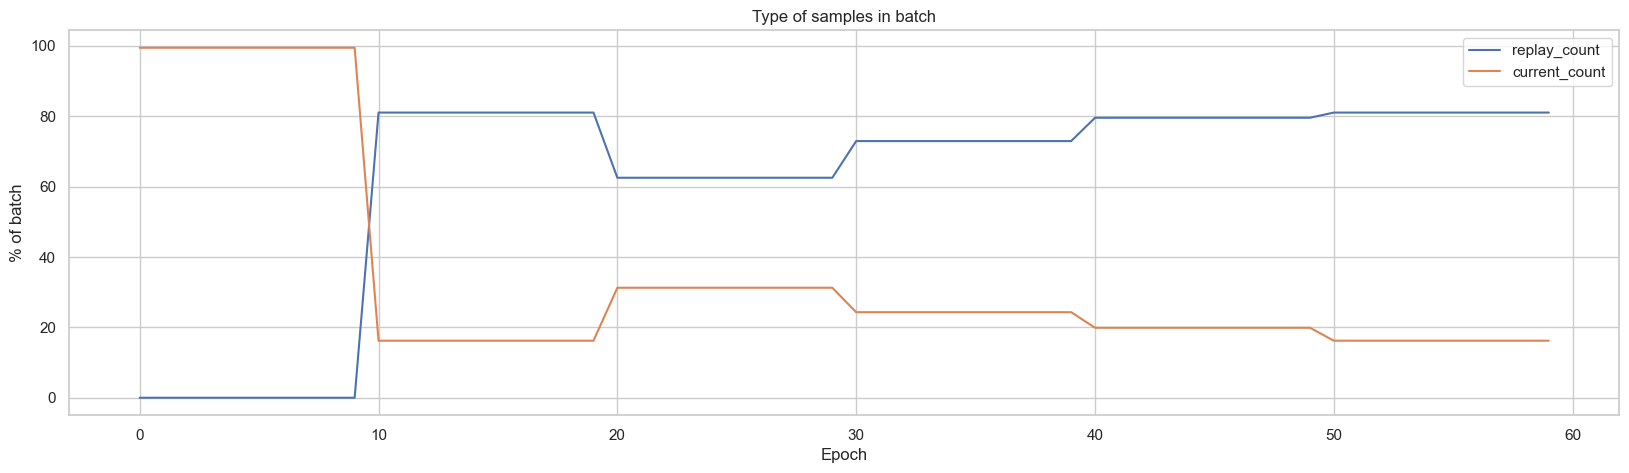

In [113]:
h = models['deep']

plt.figure(figsize=(20,5))
for metric in ['replay_count', 'current_count']:
    plt.plot([m[metric]/32*100 for m in h['train_epoch_metrics']], label=metric)
plt.title('Type of samples in batch')
plt.xlabel('Epoch')
plt.ylabel('% of batch')
# plt.axhline(32, color='r')
# plt.xticks(np.arange(0, 60, step=1))
plt.legend()
plt.show()

In [ ]:
h = models['deep_norm']

print(h['grad_norms'][0].keys())
for grad_dict in h['grad_norms']:
    for key in h['grad_norms'][0].keys():
        grad_dict.setdefault(key, 0)

In [ ]:
plt.figure(figsize=(20,5))
# for module in ['invariant', 'specific_residual', 'domain_classifier']:
for module in h['grad_norms'][0].keys():
    plt.plot([m[f'{module}'] for m in h['grad_norms']], label=module)
plt.title('Gradient Norms by Module')
# plt.ylim(-0.001, 1)
plt.legend()

## --

In [ ]:
import glob
import re
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from ipywidgets import interact

# 1. Gather all checkpoint files
checkpoint_files = glob.glob("../checkpoints/dualbranchmodel_20250609_013632_*.pt")

# 2. Parse out the step value and sort
pattern = re.compile(r"_step(\d+)\.pt")
files_with_steps = []
for f in checkpoint_files:
    match = pattern.search(f)
    if match:
        step = int(match.group(1))
        files_with_steps.append((step, f))
files_with_steps.sort()  # Sort by step

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# 3. Precompute t-SNE for all checkpoints (0-59)
tsne_projections = []
for idx, (step, ckpt_file) in enumerate(tqdm(files_with_steps, desc="Processing checkpoints")):
    ckpt = torch.load(ckpt_file, map_location='cpu')
    data = ckpt['tsne']
    inv_feats = np.array(data['inv_feats'])
    spec_feats = np.array(data['spec_feats'])
    domain_labels = np.array(data['domain_labels'])

    tsne = TSNE(n_components=2, random_state=42)
    inv_2d = tsne.fit_transform(inv_feats)
    spec_2d = tsne.fit_transform(spec_feats)

    tsne_projections.append({
        'timeline_idx': idx,  # 0 to 59
        'inv_2d': inv_2d,
        'spec_2d': spec_2d,
        'domains': domain_labels,
        'filename': ckpt_file
    })

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# State variable for current index
current_idx = 0

# Output widget for the plot
out = widgets.Output()

# Buttons
button_prev = widgets.Button(description="Previous")
button_next = widgets.Button(description="Next")

# Precompute limits
all_x = np.concatenate([d['inv_2d'][:,0] for d in tsne_projections] + [d['spec_2d'][:,0] for d in tsne_projections])
all_y = np.concatenate([d['inv_2d'][:,1] for d in tsne_projections] + [d['spec_2d'][:,1] for d in tsne_projections])
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()

def plot_epoch(timeline_idx):
    data = tsne_projections[timeline_idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    domain_to_int = {name: i for i, name in enumerate(domains)}
    domain_ints = np.array([domain_to_int[name] for name in data['domains']])
    scatter1 = ax1.scatter(data['inv_2d'][:,0], data['inv_2d'][:,1], 
                          c=domain_ints, cmap='tab10', alpha=0.7, vmin=0, vmax=len(domains)-1)
    ax1.set_title(f"Invariant Features - Timeline {timeline_idx}")
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    scatter2 = ax2.scatter(data['spec_2d'][:,0], data['spec_2d'][:,1],
                          c=domain_ints, cmap='tab10', alpha=0.7, vmin=0, vmax=len(domains)-1)
    ax2.set_title(f"Specific Features - Timeline {timeline_idx}")
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    cbar = fig.colorbar(scatter1, ax=[ax1, ax2], label='Domain', 
                        ticks=np.arange(len(domains)), boundaries=np.arange(len(domains)+1)-0.5)
    cbar.set_ticks(np.arange(len(domains)))
    cbar.set_ticklabels(domains)
    plt.show()

def on_prev_clicked(b):
    global current_idx
    if current_idx > 0:
        current_idx -= 1
        with out:
            clear_output(wait=True)
            plot_epoch(current_idx)

def on_next_clicked(b):
    global current_idx
    if current_idx < len(tsne_projections) - 1:
        current_idx += 1
        with out:
            clear_output(wait=True)
            plot_epoch(current_idx)

button_prev.on_click(on_prev_clicked)
button_next.on_click(on_next_clicked)

# Display everything
display(widgets.HBox([button_prev, button_next]))
display(out)

# Initial plot
with out:
    plot_epoch(current_idx)

## ---

In [ ]:
# After model output
outputs = model(inputs)  # Should be in [1,5]
print(f"Output range: {outputs.min().item()}–{outputs.max().item()}")


In [ ]:
test_model = LGRBaseline().to(device)
test_optimizer = optim.Adam(test_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(0)
criterion = nn.MSELoss()

first_domain = domains[0]
train_loader = domain_dataloaders[first_domain]['train']
single_batch = next(iter(train_loader))
inputs, labels, _ = single_batch
inputs = inputs.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.float32)

# %%
num_test_epochs = 400
for epoch in range(num_test_epochs):
    test_optimizer.zero_grad()

    outputs = test_model(inputs)
    loss = criterion(outputs['output'], labels)
    
    loss.backward()
    test_optimizer.step()
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Overfit Epoch {epoch+1}/{num_test_epochs} | Loss: {loss.item():.4f}")

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# device = torch.device('cpu')torch.device("cuda" if torch.cuda.is_available() else "cpu")
domains = df['domain'].unique()

writer = SummaryWriter("visualisation/")
model = DualBranchNet().to(device)
first_domain = domains[0]
train_loader = domain_dataloaders[first_domain]['train']
single_batch = next(iter(train_loader))
inputs, labels, _ = single_batch
inputs = inputs.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.float32)
# writer.add_graph(model, inputs)

writer.close()

In [ ]:
input_names = ["image"]
output_names = ["appropriateness scores"]

torch.onnx.export(model, inputs, "model.onnx", input_names=input_names, output_names=output_names)

In [ ]:
from torchviz import make_dot

y = model(inputs)
make_dot(y.mean(), params=dict(model.named_parameters()))

In [ ]:
import torch
from torch.utils.data import DataLoader

# 1. Get a single batch from any domain's train loader
domain = domains[0]
single_batch = next(iter(domain_dataloaders[domain]['train']))


buffer = NaiveRehearsalBuffer(0)

# 4. Overfit loop for both models
def overfit_model(
    model, optimizer, batch_fn, batch_kwargs, device, num_epochs=100, exp_name="overfit"
):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss, metrics = batch_fn(model, single_batch, device, **batch_kwargs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    return losses



In [ ]:
# 5. Baseline model overfit
baseline_model = LGRBaseline().to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
baseline_losses = overfit_model(
    baseline_model, optimizer, baseline_batch, {'mse_criterion': torch.nn.MSELoss()}, device
)

# 6. DualBranch model overfit
dual_model = DualBranchNet(num_domains=len(domains)).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
dualbranch_kwargs = {
    'mse_criterion': torch.nn.MSELoss(),
    'ce_criterion': torch.nn.CrossEntropyLoss(),
    'cos_criterion': lambda a, b: (torch.nn.CosineSimilarity()(a, b) ** 2).mean(),
    'domain_to_idx': domain_to_idx,
    'current_domain': domain
}
dualbranch_losses = overfit_model(
    dual_model, optimizer, dualbranch_batch, dualbranch_kwargs, device
)



In [ ]:
# 7. Plot the loss curves (optional)
import matplotlib.pyplot as plt
plt.plot(baseline_losses, label='Baseline')
plt.plot(dualbranch_losses, label='DualBranch')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Overfitting to a Single Batch')
plt.show()
